In [1]:
import ssm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

d:\download_files\Anaconda_app\anaconda_files\envs\env_py_36\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get all 39 sessions
alldat = np.array([])
for j in range(3):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
                              
alldat.shape

(39,)

In [11]:
dat = alldat[11]   # a dict
print('keys:', len(dat.keys()), dat.keys())

print('')
print('mouse_name:', dat['mouse_name'])
print('date_exp:', dat['date_exp'])
print('brain_area:', dat['brain_area'].shape, np.unique(dat['brain_area']))

print('')
print('bin_size:', dat['bin_size'])
print('stim_onset:', dat['stim_onset'])
print('spks(neurons*trials*time_bins):', dat['spks'].shape, np.unique(dat['spks']))

print('')
print('gocue:', dat['gocue'].shape)
print('contrast_right:', dat['contrast_right'].shape, np.unique(dat['contrast_right']))
print('contrast_left:', dat['contrast_left'].shape, np.unique(dat['contrast_left']))
print('feedback_time:', dat['feedback_time'].shape)
print('feedback_type:', dat['feedback_type'].shape, np.unique(dat['feedback_type']))
print('response_time:', dat['response_time'].shape)
print('response:', dat['response'].shape, np.unique(dat['response']))

print('')
print('active_trials:', dat['active_trials'].shape)
print('reaction_time:', dat['reaction_time'].shape)

print('')
print('pupil:', dat['pupil'].shape)
print('wheel:', dat['wheel'].shape)

keys: 31 dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

mouse_name: Lederberg
date_exp: 2017-12-05
brain_area: (698,) ['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp' 'root']

bin_size: 0.01
stim_onset: 0.5
spks(neurons*trials*time_bins): (698, 340, 250) [0 1 2 3 4 5 6]

gocue: (340, 1)
contrast_right: (340,) [0.   0.25 0.5  1.  ]
contrast_left: (340,) [0.   0.25 0.5  1.  ]
feedback_time: (340, 1)
feedback_type: (340,) [-1.  1.]
response_time: (340, 1)
response: (340,) [-1.  0.  1.]

active_trials: (450,)
reaction_time: (340, 2)

pupil: (3, 340, 250)
wheel: (1

In [12]:
brain_areas = dat['brain_area']
bin_size = dat['bin_size']
stim_onset = dat['stim_onset']
gocue = dat['gocue'] + stim_onset
feedback_time = dat['feedback_time'] + stim_onset
response_time = dat['response_time'] + stim_onset
neural_activity = dat['spks']

In [13]:
np.unique(brain_areas, return_counts=True)

(array(['ACA', 'CA1', 'DG', 'LGd', 'LH', 'MD', 'MOs', 'PL', 'SUB', 'VISam',
        'VISp', 'root'], dtype='<U5'),
 array([ 16,  50,  65,  11,  18, 126,   6,  56, 105,  79,  66, 100],
       dtype=int64))

In [14]:
regions = ["vis ctx", "thal", "hipp", "motor ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                [ "MOp", "MOs"],  # motor cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

nareas = 4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

np.unique(barea, return_counts=True)

(array([0., 1., 2., 3., 4.]), array([145, 155, 220,   6, 172], dtype=int64))

In [15]:
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
vis_stim = vis_left - vis_right # right - nogo - left
# trials types by response
resp_left_id = response > 0
resp_no_id = response == 0
resp_right_id = response < 0
# trials types by visual stimuli
vis_left_id = vis_stim > 0
vis_no_id = vis_stim == 0
vis_right_id = vis_stim < 0
# trials types by result
correct_id_left = np.logical_and(vis_left > 0, response > 0)
orrect_id_no = np.logical_and(vis_left == 0, response == 0)
orrect_id_right = np.logical_and(vis_left < 0, response < 0)
correct_id = np.logical_or(correct_id_left, orrect_id_no, orrect_id_right)
incorrect_id = np.logical_not(correct_id)

Motor areas in session 0

LP: -121846.1: 100%|██████████| 300/300 [00:35<00:00,  8.42it/s]


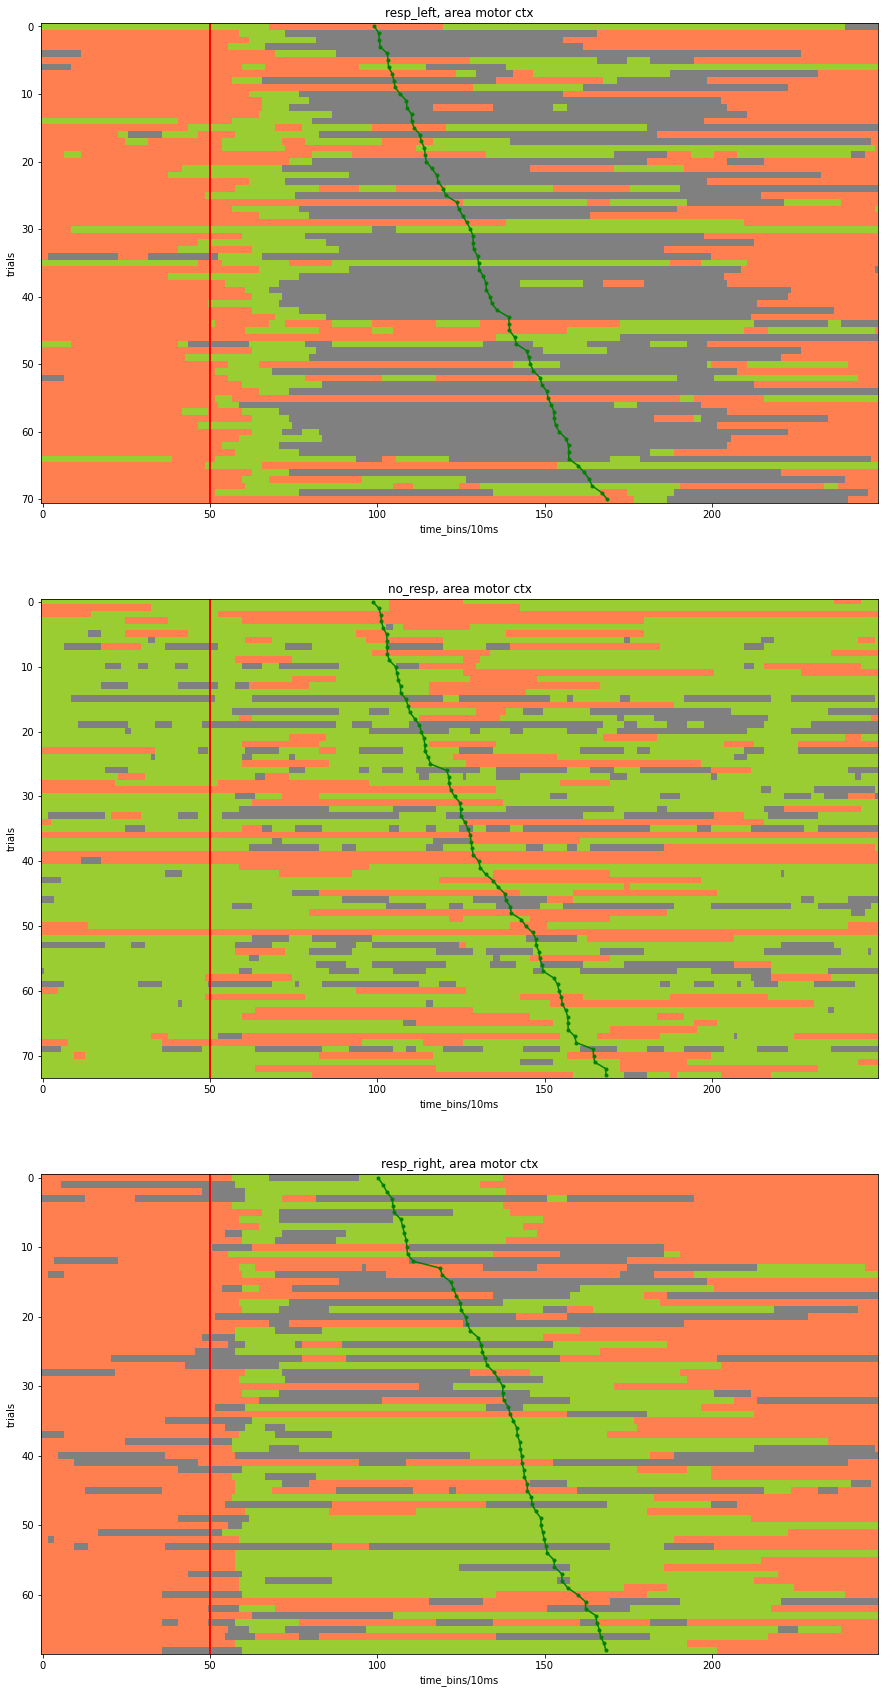

In [8]:
i_area = 3
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['resp_left', 'no_resp', 'resp_right']
f, axes = plt.subplots(nrows=3, figsize=(15, 30))

# resp_left
neural_activity_resp_left = neural_activity[barea==i_area][:, resp_left_id, :]
num_neurons = neural_activity_resp_left.shape[0]
num_trials = neural_activity_resp_left.shape[1]
resp_left_input = neural_activity_resp_left.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(resp_left_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(resp_left_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[resp_left_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[0].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[0].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[0].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[0].set_ylabel("trials")
axes[0].set_xlabel("time_bins/10ms")
axes[0].set_title(f'{trial_types[0]}, area {regions[i_area]}')

# no_resp
neural_activity_resp_no = neural_activity[barea==i_area][:, resp_no_id, :]
num_neurons = neural_activity_resp_no.shape[0]
num_trials = neural_activity_resp_no.shape[1]
resp_no_input = neural_activity_resp_no.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(resp_no_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(resp_no_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[resp_no_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[1].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[1].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[1].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[1].set_ylabel("trials")
axes[1].set_xlabel("time_bins/10ms")
axes[1].set_title(f'{trial_types[1]}, area {regions[i_area]}')

# resp_right
neural_activity_resp_right = neural_activity[barea==i_area][:, resp_right_id, :]
num_neurons = neural_activity_resp_right.shape[0]
num_trials = neural_activity_resp_right.shape[1]
resp_right_input = neural_activity_resp_right.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(resp_right_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(resp_right_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[resp_right_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[2].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[2].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[2].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[2].set_ylabel("trials")
axes[2].set_xlabel("time_bins/10ms")
axes[2].set_title(f'{trial_types[2]}, area {regions[i_area]}')

plt.tight_layout
plt.show()

LP: -172073.2: 100%|██████████| 300/300 [00:48<00:00,  6.13it/s]


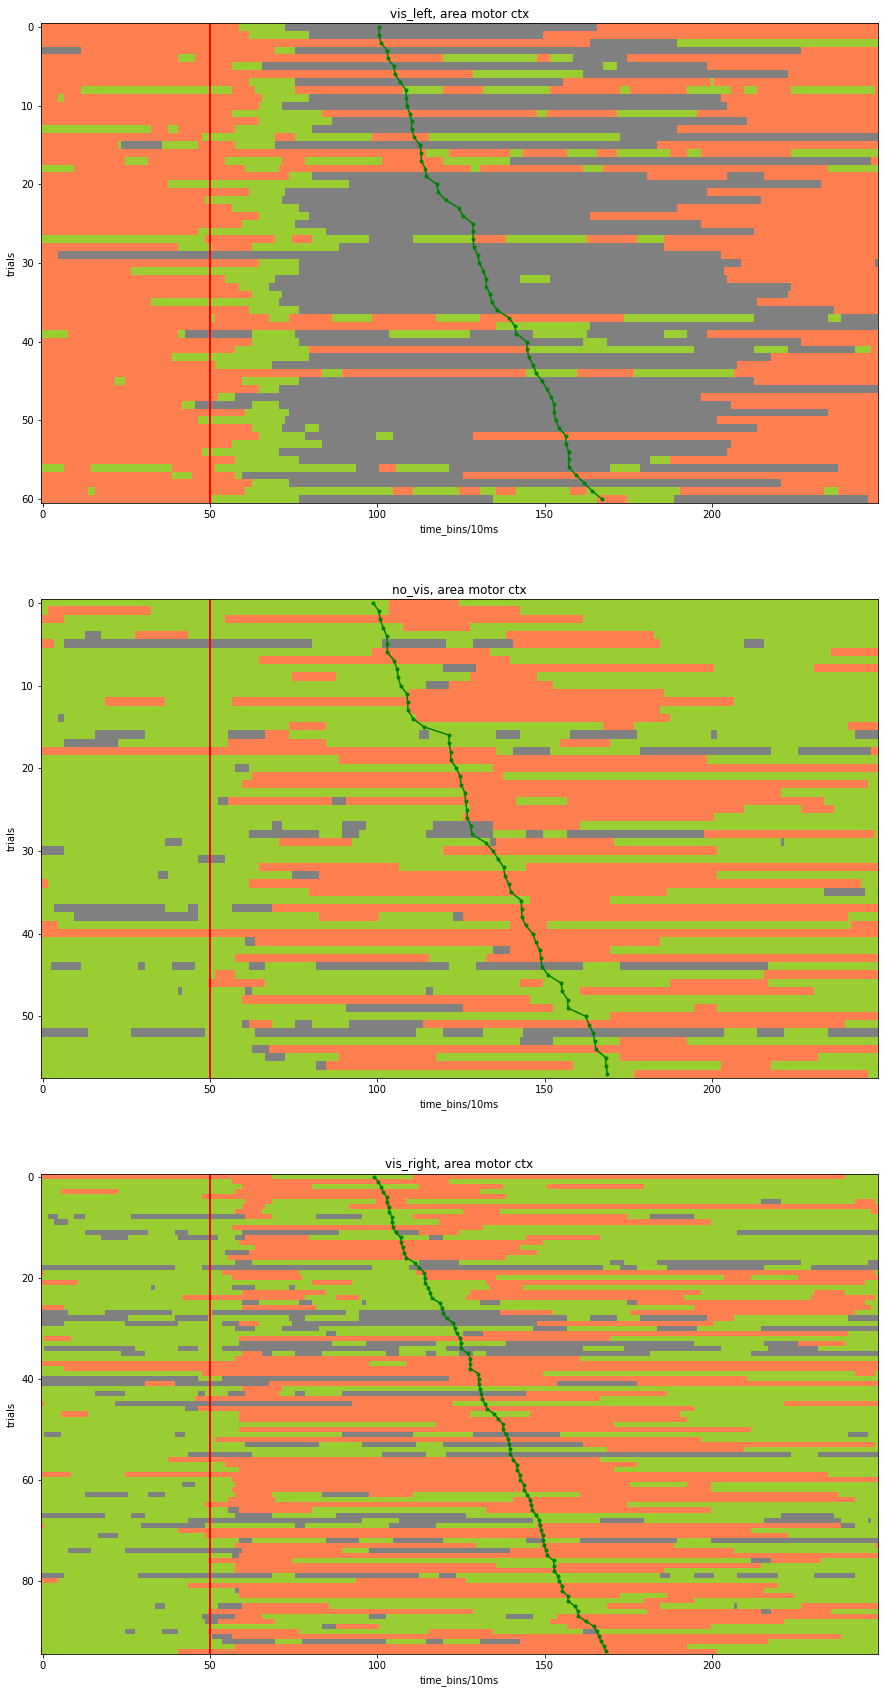

In [10]:
i_area = 3
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['vis_left', 'no_vis', 'vis_right']
f, axes = plt.subplots(nrows=3, figsize=(15, 30))

#vis_left
neural_activity_vis_left = neural_activity[barea==i_area][:, vis_left_id, :]
num_neurons = neural_activity_vis_left.shape[0]
num_trials = neural_activity_vis_left.shape[1]
vis_left_input = neural_activity_vis_left.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(vis_left_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(vis_left_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[vis_left_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[0].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[0].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[0].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[0].set_ylabel("trials")
axes[0].set_xlabel("time_bins/10ms")
axes[0].set_title(f'{trial_types[0]}, area {regions[i_area]}')

# no_vis
neural_activity_vis_no = neural_activity[barea==i_area][:, vis_no_id, :]
num_neurons = neural_activity_vis_no.shape[0]
num_trials = neural_activity_vis_no.shape[1]
vis_no_input = neural_activity_vis_no.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(vis_no_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(vis_no_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[vis_no_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[1].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[1].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[1].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[1].set_ylabel("trials")
axes[1].set_xlabel("time_bins/10ms")
axes[1].set_title(f'{trial_types[1]}, area {regions[i_area]}')

# vis_right
neural_activity_vis_right = neural_activity[barea==i_area][:, vis_right_id, :]
num_neurons = neural_activity_vis_right.shape[0]
num_trials = neural_activity_vis_right.shape[1]
vis_right_input = neural_activity_vis_right.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(vis_right_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(vis_right_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[vis_right_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[2].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[2].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[2].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[2].set_ylabel("trials")
axes[2].set_xlabel("time_bins/10ms")
axes[2].set_title(f'{trial_types[2]}, area {regions[i_area]}')

plt.tight_layout
plt.show()

LP: -186486.0: 100%|██████████| 300/300 [00:55<00:00,  5.43it/s]


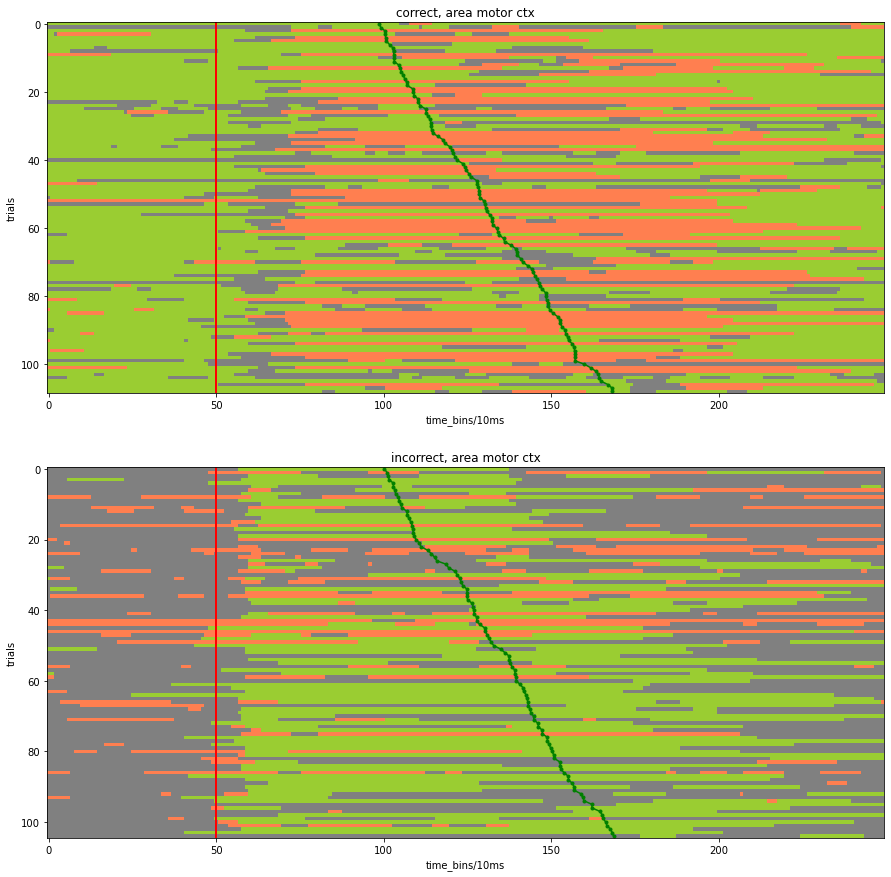

In [11]:
i_area = 3
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['correct', 'incorrect']
f, axes = plt.subplots(nrows=2, figsize=(15, 15))

#correct
neural_activity_correct = neural_activity[barea==i_area][:, correct_id, :]
num_neurons = neural_activity_correct.shape[0]
num_trials = neural_activity_correct.shape[1]
correct_input = neural_activity_correct.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(correct_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(correct_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[correct_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[0].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[0].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[0].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[0].set_ylabel("trials")
axes[0].set_xlabel("time_bins/10ms")
axes[0].set_title(f'{trial_types[0]}, area {regions[i_area]}')

# incorrect
neural_activity_incorrect = neural_activity[barea==i_area][:, incorrect_id, :]
num_neurons = neural_activity_incorrect.shape[0]
num_trials = neural_activity_incorrect.shape[1]
incorrect_input = neural_activity_incorrect.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(incorrect_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(incorrect_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[incorrect_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[1].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[1].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[1].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[1].set_ylabel("trials")
axes[1].set_xlabel("time_bins/10ms")
axes[1].set_title(f'{trial_types[1]}, area {regions[i_area]}')

plt.tight_layout
plt.show()

vis cortex in session 11

LP: -481733.7: 100%|██████████| 300/300 [02:11<00:00,  2.29it/s]


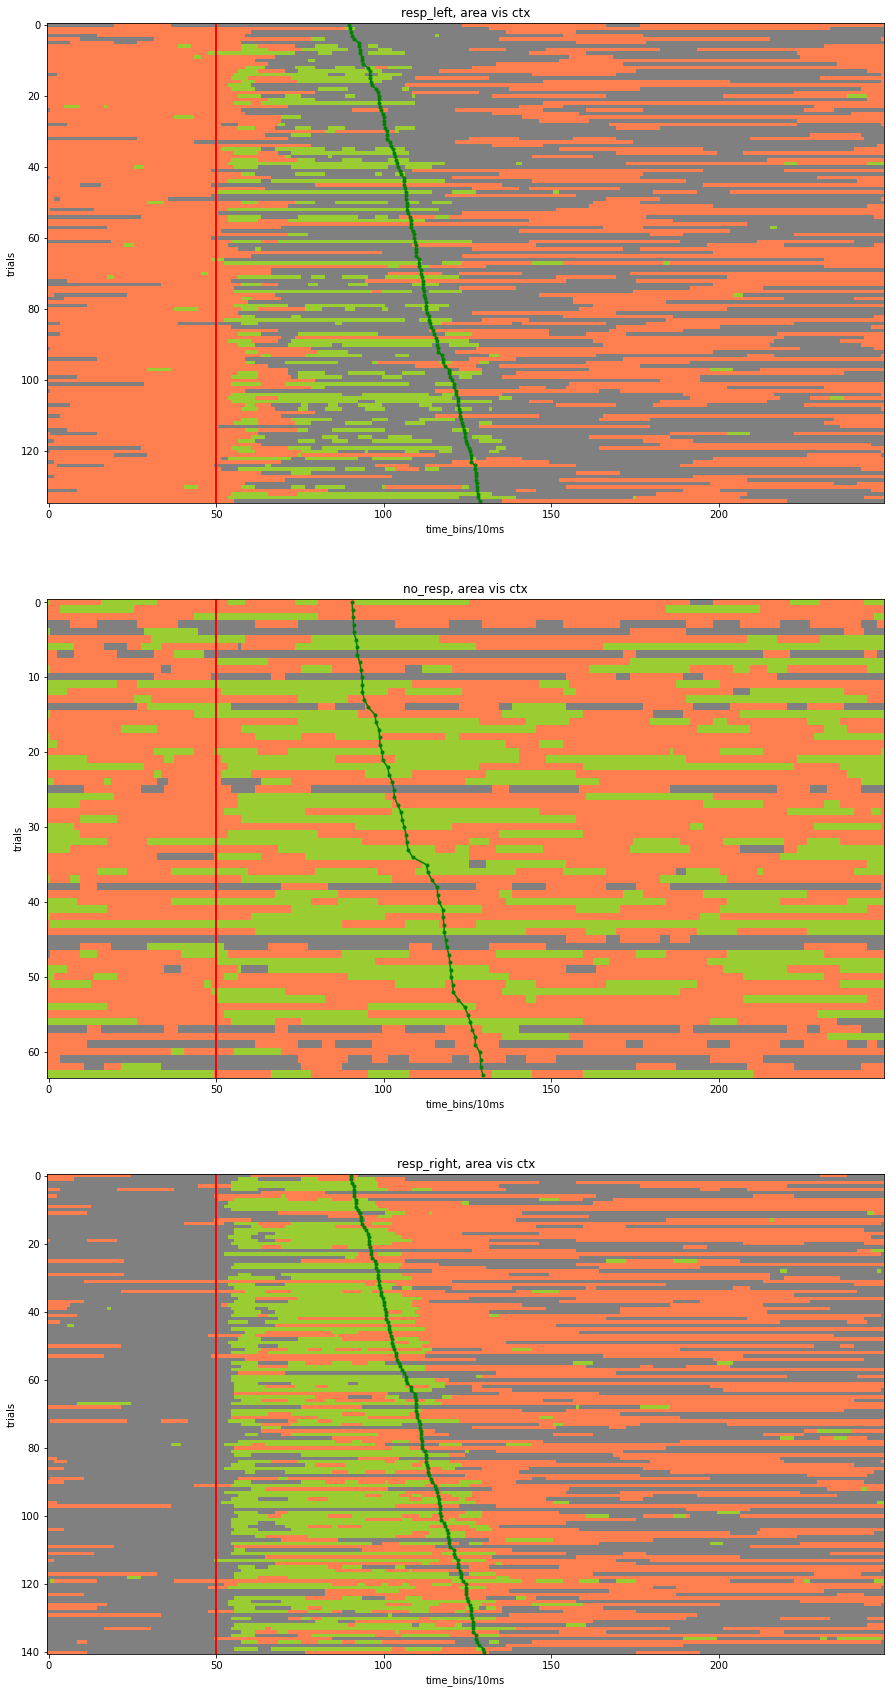

In [16]:
i_area = 0
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['resp_left', 'no_resp', 'resp_right']
f, axes = plt.subplots(nrows=3, figsize=(15, 30))

# resp_left
neural_activity_resp_left = neural_activity[barea==i_area][:, resp_left_id, :]
num_neurons = neural_activity_resp_left.shape[0]
num_trials = neural_activity_resp_left.shape[1]
resp_left_input = neural_activity_resp_left.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(resp_left_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(resp_left_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[resp_left_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[0].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[0].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[0].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[0].set_ylabel("trials")
axes[0].set_xlabel("time_bins/10ms")
axes[0].set_title(f'{trial_types[0]}, area {regions[i_area]}')

# no_resp
neural_activity_resp_no = neural_activity[barea==i_area][:, resp_no_id, :]
num_neurons = neural_activity_resp_no.shape[0]
num_trials = neural_activity_resp_no.shape[1]
resp_no_input = neural_activity_resp_no.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(resp_no_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(resp_no_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[resp_no_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[1].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[1].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[1].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[1].set_ylabel("trials")
axes[1].set_xlabel("time_bins/10ms")
axes[1].set_title(f'{trial_types[1]}, area {regions[i_area]}')

# resp_right
neural_activity_resp_right = neural_activity[barea==i_area][:, resp_right_id, :]
num_neurons = neural_activity_resp_right.shape[0]
num_trials = neural_activity_resp_right.shape[1]
resp_right_input = neural_activity_resp_right.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(resp_right_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(resp_right_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[resp_right_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[2].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[2].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[2].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[2].set_ylabel("trials")
axes[2].set_xlabel("time_bins/10ms")
axes[2].set_title(f'{trial_types[2]}, area {regions[i_area]}')

plt.tight_layout
plt.show()

LP: -405631.3: 100%|██████████| 300/300 [01:06<00:00,  4.52it/s]


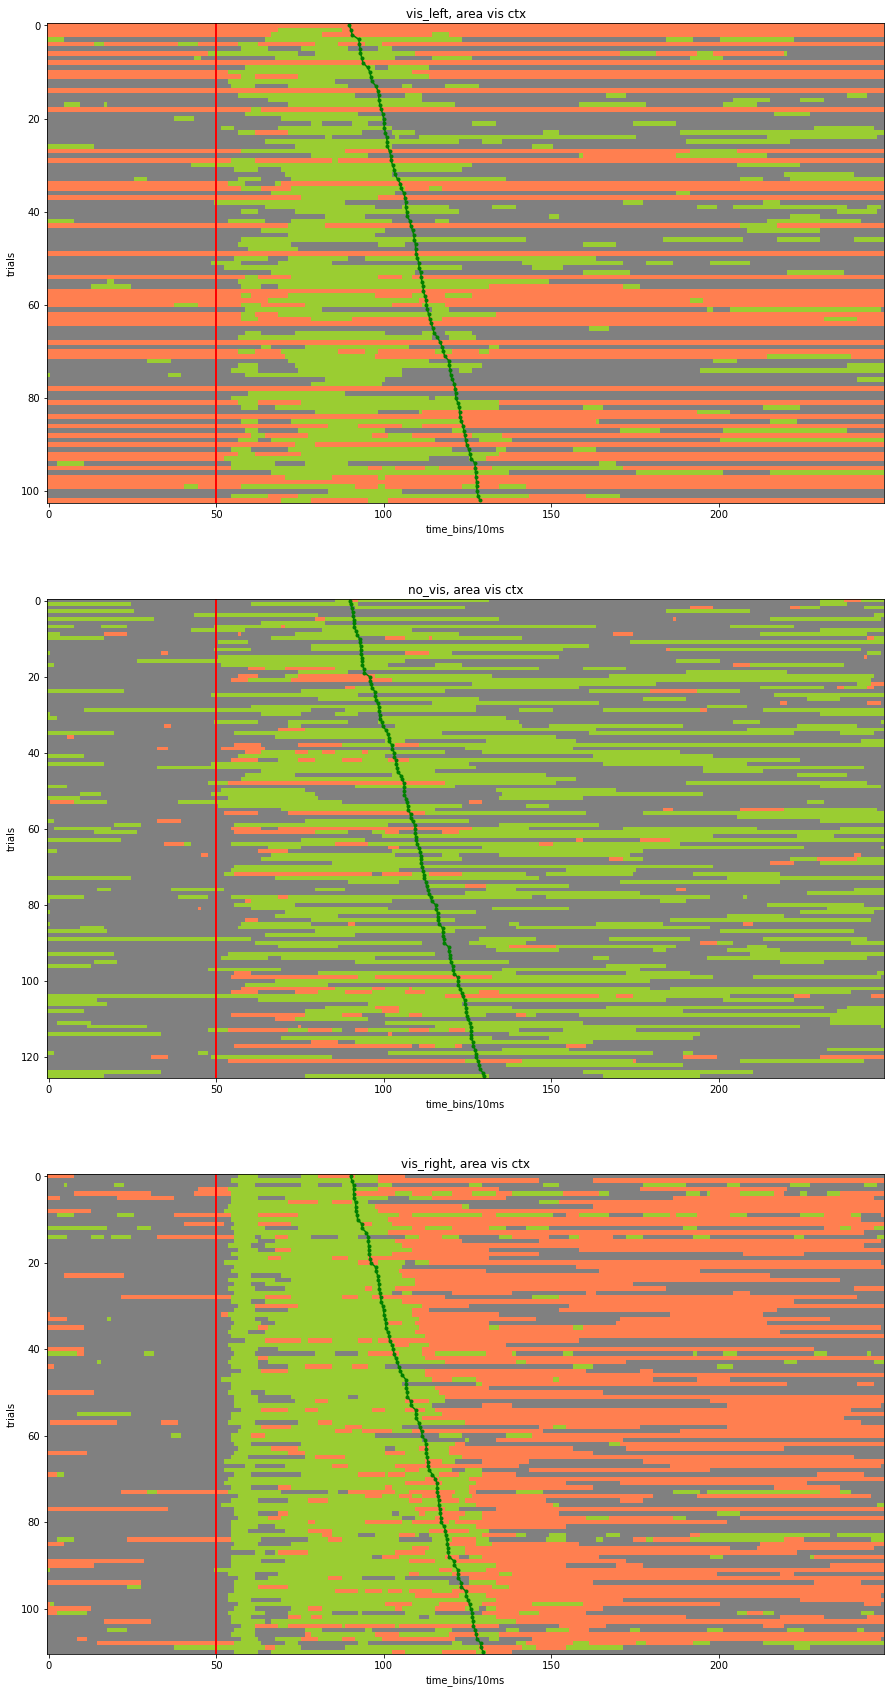

In [17]:
i_area = 0
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['vis_left', 'no_vis', 'vis_right']
f, axes = plt.subplots(nrows=3, figsize=(15, 30))

#vis_left
neural_activity_vis_left = neural_activity[barea==i_area][:, vis_left_id, :]
num_neurons = neural_activity_vis_left.shape[0]
num_trials = neural_activity_vis_left.shape[1]
vis_left_input = neural_activity_vis_left.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(vis_left_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(vis_left_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[vis_left_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[0].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[0].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[0].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[0].set_ylabel("trials")
axes[0].set_xlabel("time_bins/10ms")
axes[0].set_title(f'{trial_types[0]}, area {regions[i_area]}')

# no_vis
neural_activity_vis_no = neural_activity[barea==i_area][:, vis_no_id, :]
num_neurons = neural_activity_vis_no.shape[0]
num_trials = neural_activity_vis_no.shape[1]
vis_no_input = neural_activity_vis_no.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(vis_no_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(vis_no_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[vis_no_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[1].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[1].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[1].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[1].set_ylabel("trials")
axes[1].set_xlabel("time_bins/10ms")
axes[1].set_title(f'{trial_types[1]}, area {regions[i_area]}')

# vis_right
neural_activity_vis_right = neural_activity[barea==i_area][:, vis_right_id, :]
num_neurons = neural_activity_vis_right.shape[0]
num_trials = neural_activity_vis_right.shape[1]
vis_right_input = neural_activity_vis_right.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(vis_right_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(vis_right_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[vis_right_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[2].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[2].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[2].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[2].set_ylabel("trials")
axes[2].set_xlabel("time_bins/10ms")
axes[2].set_title(f'{trial_types[2]}, area {regions[i_area]}')

plt.tight_layout
plt.show()

LP: -539075.1: 100%|██████████| 300/300 [01:35<00:00,  3.14it/s]


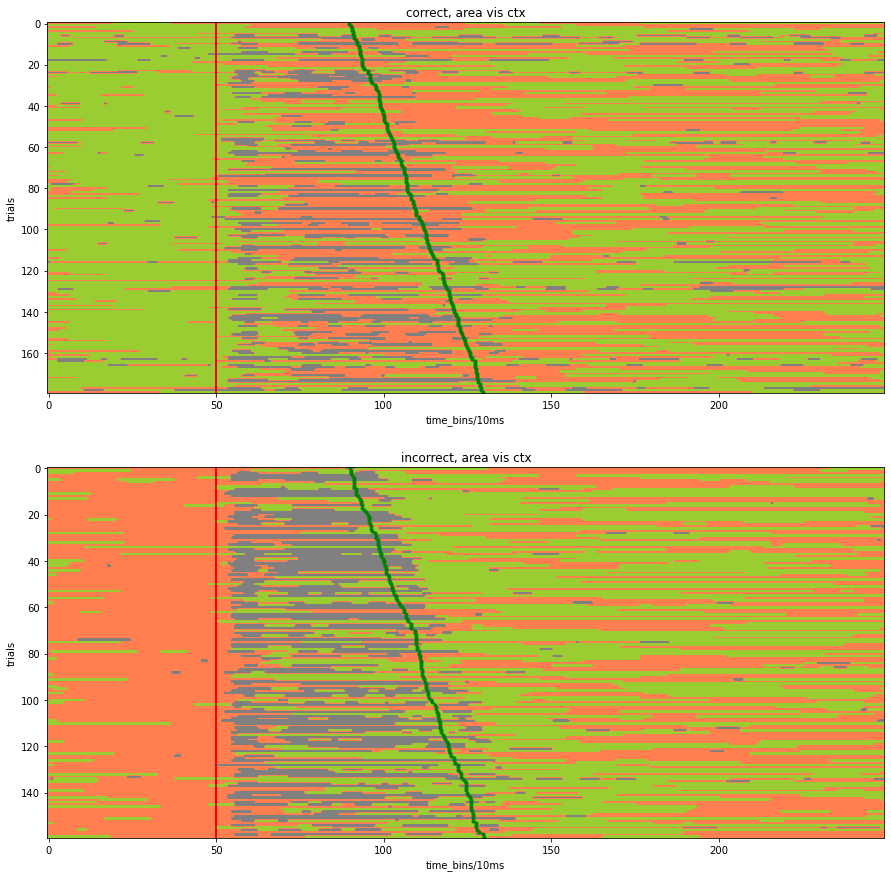

In [18]:
i_area = 0
n_trial = 4
num_states = 3
time_bins = neural_activity.shape[2]
trial_types = ['correct', 'incorrect']
f, axes = plt.subplots(nrows=2, figsize=(15, 15))

#correct
neural_activity_correct = neural_activity[barea==i_area][:, correct_id, :]
num_neurons = neural_activity_correct.shape[0]
num_trials = neural_activity_correct.shape[1]
correct_input = neural_activity_correct.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(correct_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(correct_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[correct_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[0].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[0].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[0].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[0].set_ylabel("trials")
axes[0].set_xlabel("time_bins/10ms")
axes[0].set_title(f'{trial_types[0]}, area {regions[i_area]}')

# incorrect
neural_activity_incorrect = neural_activity[barea==i_area][:, incorrect_id, :]
num_neurons = neural_activity_incorrect.shape[0]
num_trials = neural_activity_incorrect.shape[1]
incorrect_input = neural_activity_incorrect.reshape(num_neurons, num_trials*time_bins)

p_hmm = ssm.HMM(num_states, num_neurons, observations="poisson")
p_hmm.fit(incorrect_input.T, method="em", num_iters = 300)
states_seq = p_hmm.most_likely_states(incorrect_input.T)

states_mat = states_seq.reshape(num_trials, time_bins)
go_cue_array = gocue[incorrect_id]/bin_size
go_cue_array = go_cue_array.flatten()
go_cue_idx = np.argsort(go_cue_array)

go_cue_sorted = go_cue_array[go_cue_idx]
states_mat_sorted = states_mat[go_cue_idx, :]

cmp = mpl.colors.ListedColormap(['yellowgreen', 'coral', 'gray'])
axes[1].imshow(states_mat_sorted, aspect='auto', cmap=cmp)
axes[1].axvline(x=stim_onset/bin_size, color='red', linewidth=2, label='stim_onset')
axes[1].plot(go_cue_sorted, np.arange(num_trials), color='green', marker='.', label='go_cue')
# axes[2*i+1].plot(feedback_time[resp_right_id]/bin_size, np.arange(num_trials), color='blue', marker='.', label='feedback_time')
# axes[2*i+1].plot(response_time[resp_right_id]/bin_size, np.arange(num_trials), color='yellow', marker='.', label='response_time')
axes[1].set_ylabel("trials")
axes[1].set_xlabel("time_bins/10ms")
axes[1].set_title(f'{trial_types[1]}, area {regions[i_area]}')

plt.tight_layout
plt.show()